Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

Оператор предоставляет два основных типа услуг:
1. Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
2. Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:
1. Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
2. Выделенная линия технической поддержки (Tech Support);
3. Облачное хранилище файлов для резервного копирования данных (Online Backup);
4. Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).


За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

## Описание данных

Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:
• contract — информация о договорах;
• personal — персональные данные клиентов;
• internet — информация об интернет-услугах;
• phone — информация об услугах телефонии.

Таблица contract

• customerID — ID абонента;

• BeginDate — дата начала действия договора;

• EndDate — дата окончания действия договора;

• Type — тип оплаты: раз в год-два или ежемесячно;

• PaperlessBilling — электронный расчётный лист;

• PaymentMethod — тип платежа;

• MonthlyCharges — расходы за месяц;

• TotalCharges — общие расходы абонента

Таблица personal

• customerID — ID пользователя;

• gender — пол;

• SeniorCitizen — является ли абонент пенсионером;

• Partner — есть ли у абонента супруг или супруга;

• Dependents — есть ли у абонента дети.

Таблица internet

• customerID — ID пользователя;

• InternetService — тип подключения;

• OnlineSecurity — блокировка опасных сайтов;

• OnlineBackup — облачное хранилище файлов для резервного копирования данных;

• DeviceProtection — антивирус;

• TechSupport — выделенная линия технической поддержки;

• StreamingTV — стриминговое телевидение;

• StreamingMovies — каталог фильмов.

Таблица phone

• customerID — ID пользователя;

• MultipleLines — подключение телефона к нескольким линиям одновременно.

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer, confusion_matrix, classification_report
from sklearn.exceptions import ConvergenceWarning
from sklearn.inspection import permutation_importance

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

import phik
from phik.report import plot_correlation_matrix

## Загрузка данных

In [3]:
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db -O ds-plus-final.db

In [4]:
Path = 'ds-plus-final.db'

In [5]:
con = sqlite3.connect(Path)

In [6]:
contract = pd.read_sql_query("SELECT * FROM contract", con)
personal = pd.read_sql_query("SELECT * FROM personal", con)
internet = pd.read_sql_query("SELECT * FROM internet", con)
phone = pd.read_sql_query("SELECT * FROM phone", con)

In [7]:
RANDOM_STATE = 120824

## Исследовательский анализ и предобработка данных

Проверка размеров таблиц

In [8]:
print("Размер таблицы contract:", contract.shape)
print("Размер таблицы personal:", personal.shape)
print("Размер таблицы internet:", internet.shape)
print("Размер таблицы phone:", phone.shape)

Размер таблицы contract: (7043, 8)
Размер таблицы personal: (7043, 5)
Размер таблицы internet: (5517, 8)
Размер таблицы phone: (6361, 2)


Проверка информации о таблицах

In [9]:
print("Размер таблицы contract:", contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB
Размер таблицы contract: None


In [10]:
print("Размер таблицы personal:", personal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB
Размер таблицы personal: None


In [11]:
print("Размер таблицы internet:", internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
Размер таблицы internet: None


In [12]:
print("Размер таблицы phone:", phone.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
Размер таблицы phone: None


Проверка на пропуски и аномалии

In [13]:
print("Пропуски в таблице contract:", contract.isnull().sum())
print(contract.describe())

Пропуски в таблице contract: customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
        customerID   BeginDate EndDate            Type PaperlessBilling  \
count         7043        7043    7043            7043             7043   
unique        7043          77      67               3                2   
top     7590-VHVEG  2014-02-01      No  Month-to-month              Yes   
freq             1         366    5942            3875             4171   

           PaymentMethod MonthlyCharges TotalCharges  
count               7043           7043         7043  
unique                 4           1585         6658  
top     Electronic check          20.05               
freq                2365             61           11  


In [14]:
print("Пропуски в таблице personal:", personal.isnull().sum())
print(personal.describe())

Пропуски в таблице personal: customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
        customerID gender SeniorCitizen Partner Dependents
count         7043   7043          7043    7043       7043
unique        7043      2             2       2          2
top     7590-VHVEG   Male             0      No         No
freq             1   3555          5901    3641       4933


In [15]:
print("Пропуски в таблице internet", internet.isnull().sum())
print(internet.describe())

Пропуски в таблице internet customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2           2               2  
top                  No          No          No              No  
freq               3095        3473        2810            2785  


In [16]:
print("Пропуски в таблице phone", phone.isnull().sum())
print(phone.describe())

Пропуски в таблице phone CustomerId       0
MultipleLines    0
dtype: int64
        CustomerId MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390


Проверка проблем с датами договоров

In [17]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')

C:\Users\PC\AppData\Local\Temp\ipykernel_2468\2719333753.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')


In [18]:
actual_date = pd.to_datetime('2020-02-01')

In [19]:
print(f"Количество договоров в таблице contract, завершившихся после {actual_date.date()}: {(contract['EndDate'] > actual_date).sum()}")

Количество договоров в таблице contract, завершившихся после 2020-02-01: 0


In [20]:
print(f"Количество договоров в таблице contract, начавшихся после {actual_date.date()}: {(contract['BeginDate'] > actual_date).sum()}")

Количество договоров в таблице contract, начавшихся после 2020-02-01: 0


In [21]:
print(f"Количество договоров в таблице contract, у которых дата начала позже даты окончания: {(contract['BeginDate'] > contract['EndDate']).sum()}")

Количество договоров в таблице contract, у которых дата начала позже даты окончания: 0


Можно проводить объединение.

In [22]:
print("Столбцы таблицы contract:", contract.columns)
print("Столбцы таблицы personal:", personal.columns)
print("Столбцы таблицы internet:", internet.columns)
print("Столбцы таблицы phone:", phone.columns)

Столбцы таблицы contract: Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')
Столбцы таблицы personal: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')
Столбцы таблицы internet: Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')
Столбцы таблицы phone: Index(['CustomerId', 'MultipleLines'], dtype='object')


In [23]:
phone.rename(columns={'CustomerId': 'customerID'}, inplace=True)

Проблема с объединением решена.

In [24]:
data = contract.merge(personal, on='customerID', how='left')\
                      .merge(internet, on='customerID', how='left')\
                      .merge(phone, on='customerID', how='left')

In [25]:
print("Размер объединенной таблицы:", data.shape)

Размер объединенной таблицы: (7043, 20)


In [26]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   object        
 7   TotalCharges      7043 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

In [27]:
display (data.head(30))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.3,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.7,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,NaT,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.1,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,NaT,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,NaT,Month-to-month,Yes,Electronic check,104.8,3573.68,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [28]:
print("Количество пропусков в каждом столбце:", data.isnull().sum())

Количество пропусков в каждом столбце: customerID             0
BeginDate              0
EndDate             5942
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


Меня очень волнует NaT в EndDate. Я решила создать признак ContractTerminated, который будет показывать, разорван контракт или нет. Также заполню все пропуски актуальной датой как в задании (1 февраля 2020) для продолжающихся договоров.

In [29]:
end_date_fill = pd.Timestamp('2020-02-01')

In [30]:
data['ContractTerminated'] = data['EndDate'].notnull().astype(int)
data['EndDate'] = data['EndDate'].fillna(end_date_fill)

In [31]:
display (data.head(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractTerminated
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.3,1960.6,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.7,353.5,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customerID          7043 non-null   object        
 1   BeginDate           7043 non-null   datetime64[ns]
 2   EndDate             7043 non-null   datetime64[ns]
 3   Type                7043 non-null   object        
 4   PaperlessBilling    7043 non-null   object        
 5   PaymentMethod       7043 non-null   object        
 6   MonthlyCharges      7043 non-null   object        
 7   TotalCharges        7043 non-null   object        
 8   gender              7043 non-null   object        
 9   SeniorCitizen       7043 non-null   object        
 10  Partner             7043 non-null   object        
 11  Dependents          7043 non-null   object        
 12  InternetService     5517 non-null   object        
 13  OnlineSecurity      5517 non-null   object      

Дальше проверяю уникальные данные в стобцах.

Функция для проверки уникальных значений, чтобы не писать ее каждый раз

In [33]:
def check_unique_values(df, columns):
    for column in columns:
        unique_values = df[column].unique()
        print(f"Уникальные значения в столбце '{column}': {unique_values}\n")

In [34]:
check_unique_values(data, ['Type'])

Уникальные значения в столбце 'Type': ['Month-to-month' 'One year' 'Two year']



In [35]:
check_unique_values(data, ['PaperlessBilling'])

Уникальные значения в столбце 'PaperlessBilling': ['Yes' 'No']



In [36]:
check_unique_values(data, ['gender'])

Уникальные значения в столбце 'gender': ['Female' 'Male']



In [37]:
check_unique_values(data, ['SeniorCitizen'])

Уникальные значения в столбце 'SeniorCitizen': ['0' '1']



In [38]:
check_unique_values(data, ['Partner'])

Уникальные значения в столбце 'Partner': ['Yes' 'No']



In [39]:
check_unique_values(data, ['Dependents'])

Уникальные значения в столбце 'Dependents': ['No' 'Yes']



In [40]:
check_unique_values(data, ['InternetService'])

Уникальные значения в столбце 'InternetService': ['DSL' 'Fiber optic' nan]



In [41]:
check_unique_values(data, ['OnlineSecurity'])

Уникальные значения в столбце 'OnlineSecurity': ['No' 'Yes' nan]



In [42]:
check_unique_values(data, ['OnlineBackup'])

Уникальные значения в столбце 'OnlineBackup': ['Yes' 'No' nan]



In [43]:
check_unique_values(data, ['DeviceProtection'])

Уникальные значения в столбце 'DeviceProtection': ['No' 'Yes' nan]



In [44]:
check_unique_values(data, ['TechSupport'])

Уникальные значения в столбце 'TechSupport': ['No' 'Yes' nan]



In [45]:
check_unique_values(data, ['StreamingTV'])

Уникальные значения в столбце 'StreamingTV': ['No' 'Yes' nan]



In [46]:
check_unique_values(data, ['StreamingMovies'])

Уникальные значения в столбце 'StreamingMovies': ['No' 'Yes' nan]



In [47]:
check_unique_values(data, ['MultipleLines'])

Уникальные значения в столбце 'MultipleLines': [nan 'No' 'Yes']



Имеется множество пропусков, связанных с интернетом и мультилиниями. Если у присоединенных пользователей в таблице есть nan, значит, что пользователь не пользуется данными услугами и они не были ему предложены, поэтому Nan.

In [48]:
columns_to_fill = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 
                   'StreamingMovies', 'MultipleLines']

In [49]:
for column in columns_to_fill:
    data[column] = data[column].fillna('Nan')

In [50]:
check_unique_values(data, ['MultipleLines'])

Уникальные значения в столбце 'MultipleLines': ['Nan' 'No' 'Yes']



In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customerID          7043 non-null   object        
 1   BeginDate           7043 non-null   datetime64[ns]
 2   EndDate             7043 non-null   datetime64[ns]
 3   Type                7043 non-null   object        
 4   PaperlessBilling    7043 non-null   object        
 5   PaymentMethod       7043 non-null   object        
 6   MonthlyCharges      7043 non-null   object        
 7   TotalCharges        7043 non-null   object        
 8   gender              7043 non-null   object        
 9   SeniorCitizen       7043 non-null   object        
 10  Partner             7043 non-null   object        
 11  Dependents          7043 non-null   object        
 12  InternetService     7043 non-null   object        
 13  OnlineSecurity      7043 non-null   object      

Преобразую MonthlyCharges и TotalCharges в числовой тип.

In [52]:
data['MonthlyCharges'] = pd.to_numeric(data['MonthlyCharges'], errors='coerce')
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [53]:
print(data[['MonthlyCharges', 'TotalCharges']].isnull().sum())

MonthlyCharges     0
TotalCharges      11
dtype: int64


In [54]:
missing_totalcharges = data[data['TotalCharges'].isnull()]
print(missing_totalcharges)

      customerID  BeginDate    EndDate      Type PaperlessBilling  \
488   4472-LVYGI 2020-02-01 2020-02-01  Two year              Yes   
753   3115-CZMZD 2020-02-01 2020-02-01  Two year               No   
936   5709-LVOEQ 2020-02-01 2020-02-01  Two year               No   
1082  4367-NUYAO 2020-02-01 2020-02-01  Two year               No   
1340  1371-DWPAZ 2020-02-01 2020-02-01  Two year               No   
3331  7644-OMVMY 2020-02-01 2020-02-01  Two year               No   
3826  3213-VVOLG 2020-02-01 2020-02-01  Two year               No   
4380  2520-SGTTA 2020-02-01 2020-02-01  Two year               No   
5218  2923-ARZLG 2020-02-01 2020-02-01  One year              Yes   
6670  4075-WKNIU 2020-02-01 2020-02-01  Two year               No   
6754  2775-SEFEE 2020-02-01 2020-02-01  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  gender  \
488   Bank transfer (automatic)           52.55           NaN  Female   
753                Mailed

In [55]:
data.loc[(data['TotalCharges'].isnull()) & (data['MonthlyCharges'] > 0), 'TotalCharges'] = data['MonthlyCharges']

In [56]:
print(data[['MonthlyCharges', 'TotalCharges']].isnull().sum())

MonthlyCharges    0
TotalCharges      0
dtype: int64


Пропуски возникли из-за того, что клиенты новые.

## Промежуточный вывод

Проведена работа с EndDate: последней датой у действующих договоров проставлена 1 февраля 2020.

Создана переменная ContractTerminated - разорван договор или нет.

Пропуски, связанные с интернетом, заполнены на Nan, если у абонента нет интернетаи мультилиний.

Также проведена работа с числовыми MonthlyCharges и TotalCharges: их тип изменен в соответствии со значениями, пропуски у новых абонентов также заполнены.

Визуализация признаков

In [57]:
categorical_columns = [
    'Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 
    'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
    'StreamingMovies', 'MultipleLines'
]

Проведу визуализацию категориальных признаков по целевому признаку, чтобы понять распределение ушедших и оставшихся клиентов.

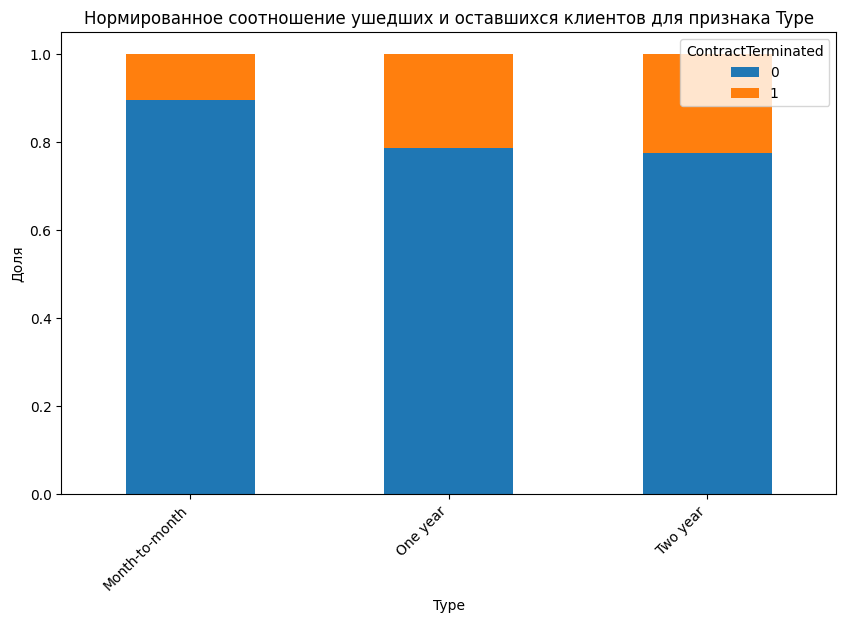

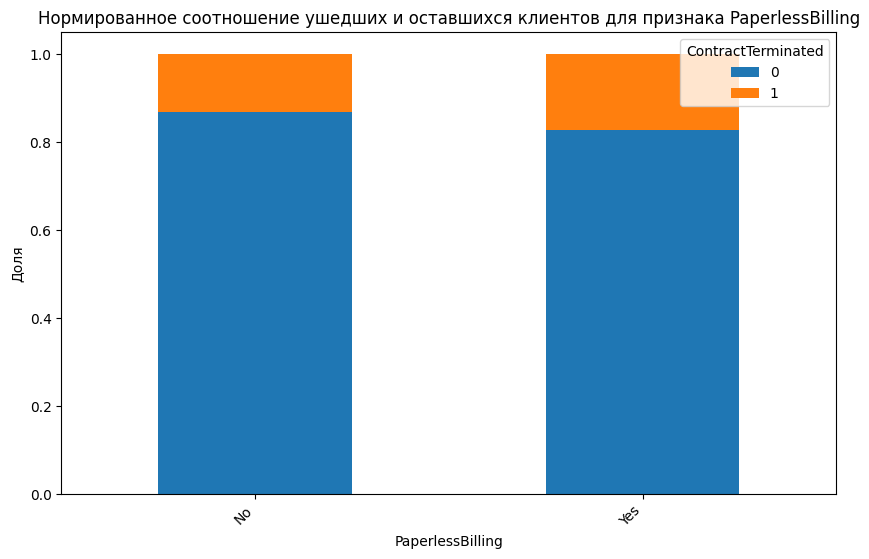

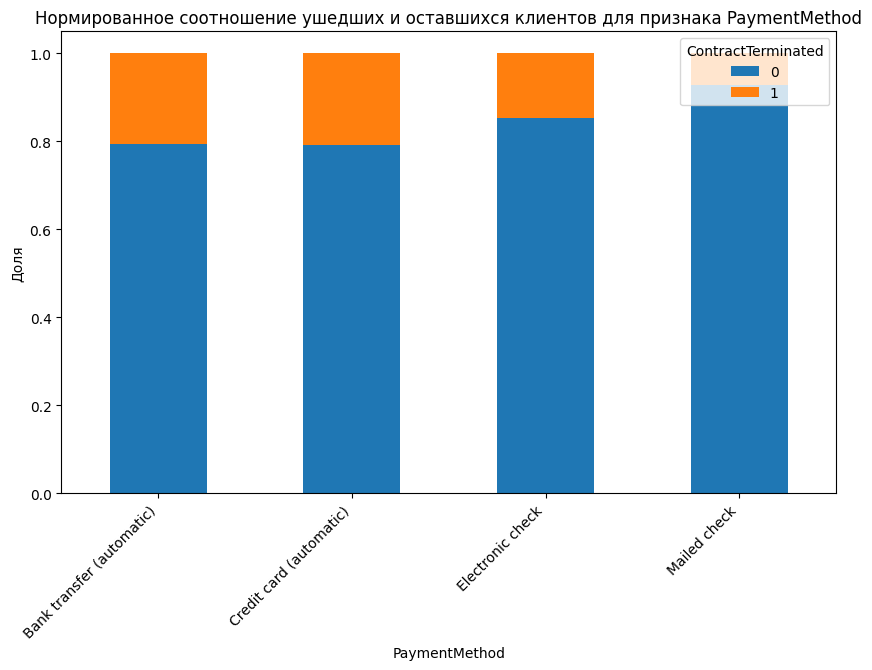

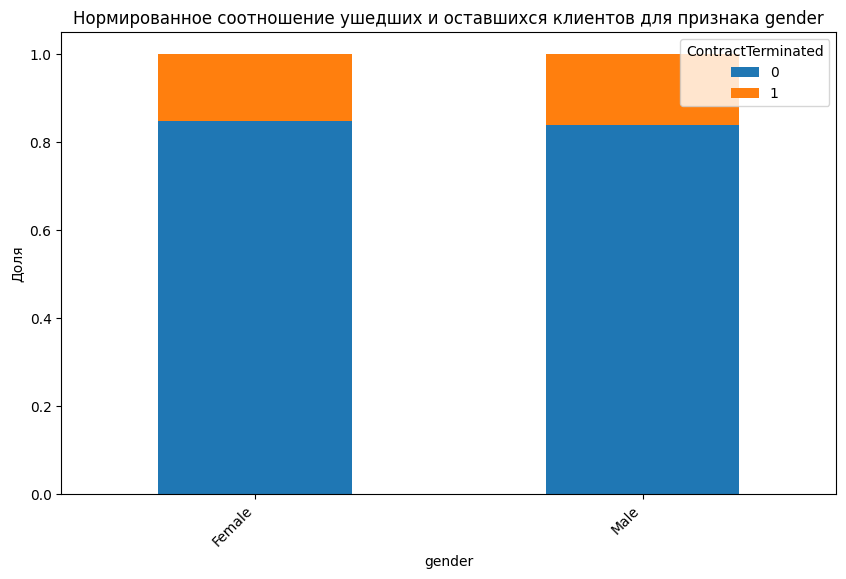

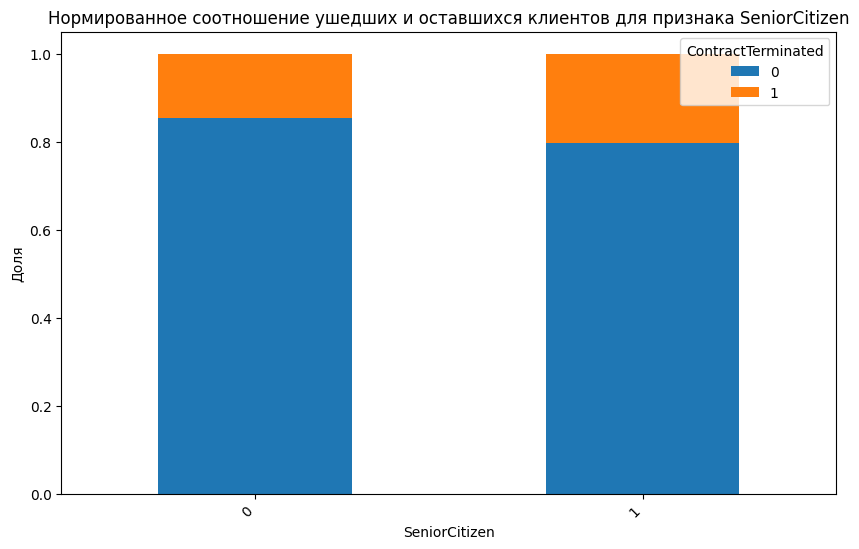

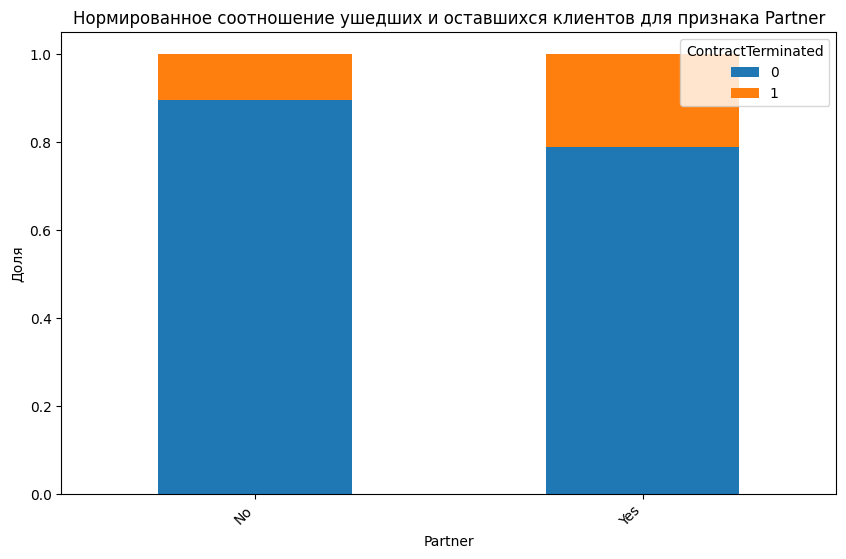

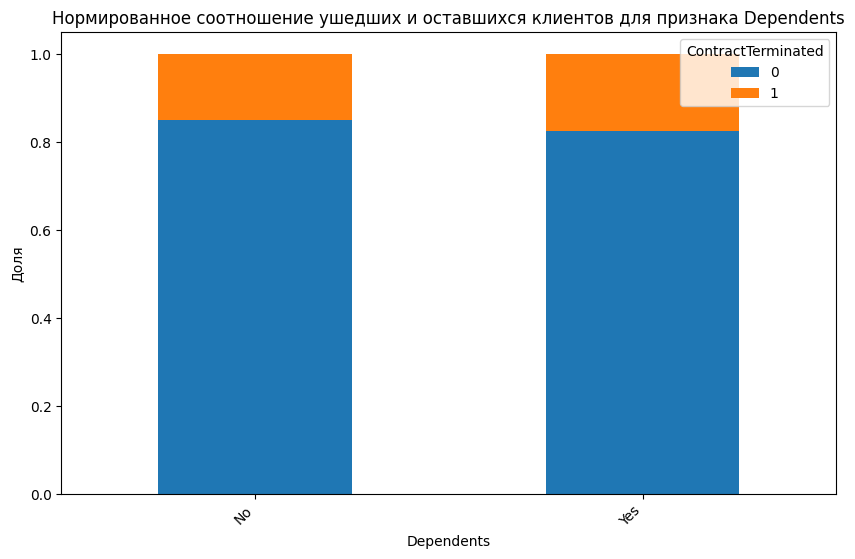

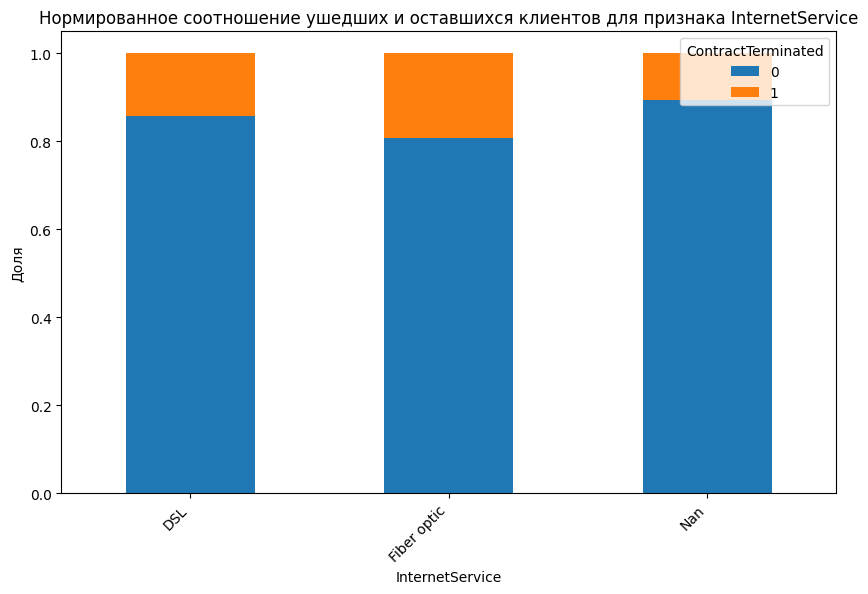

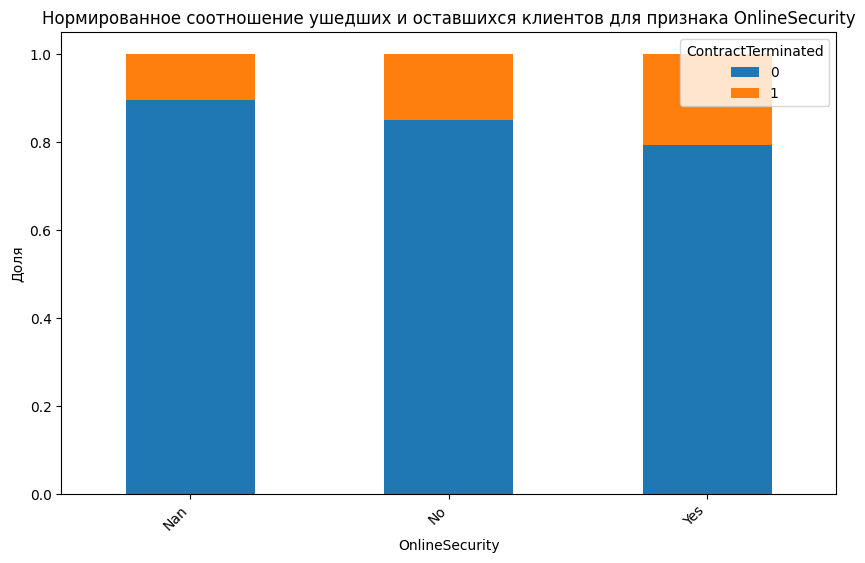

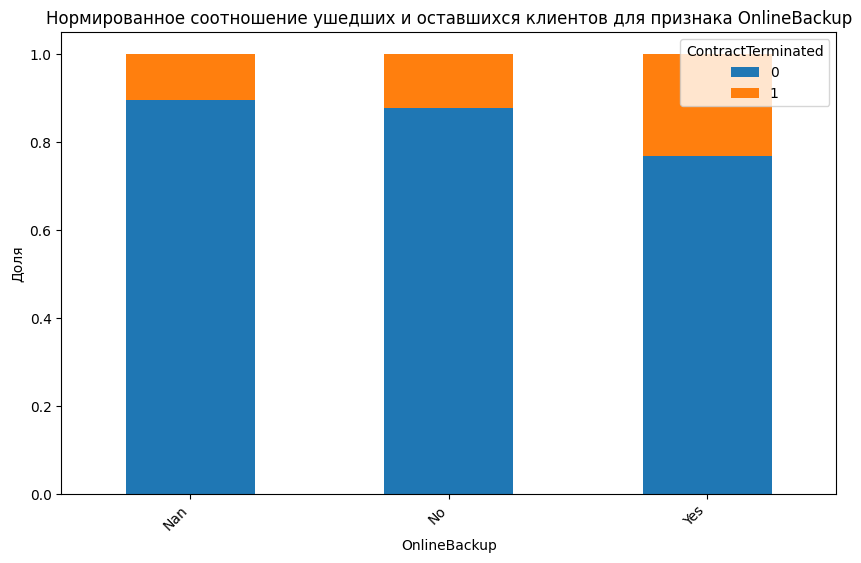

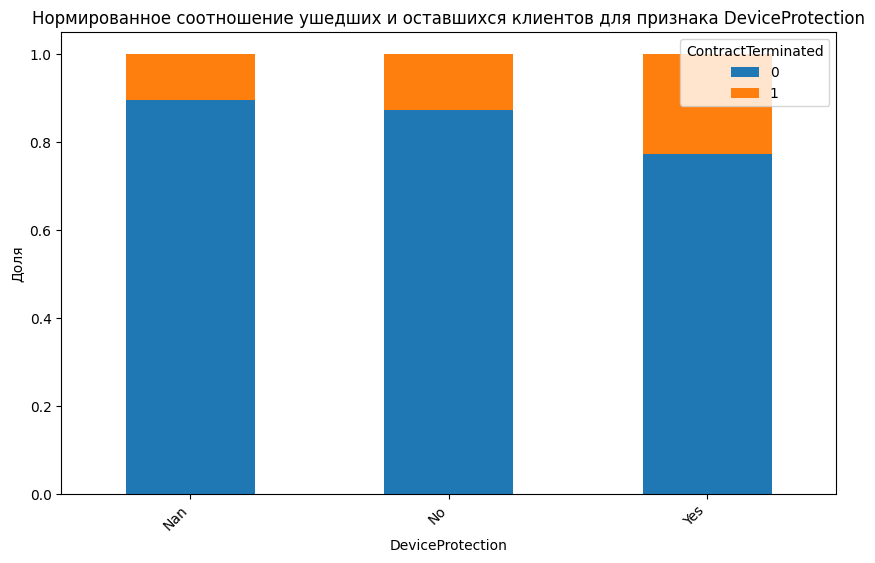

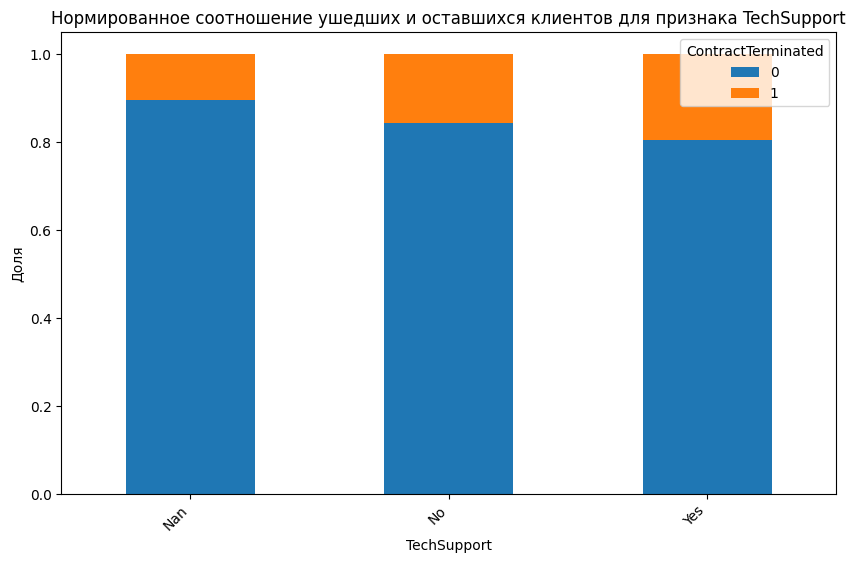

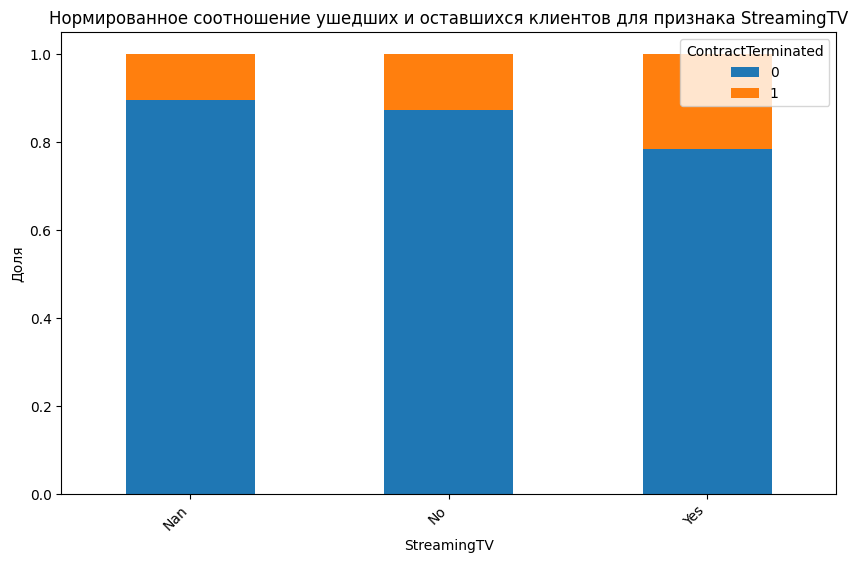

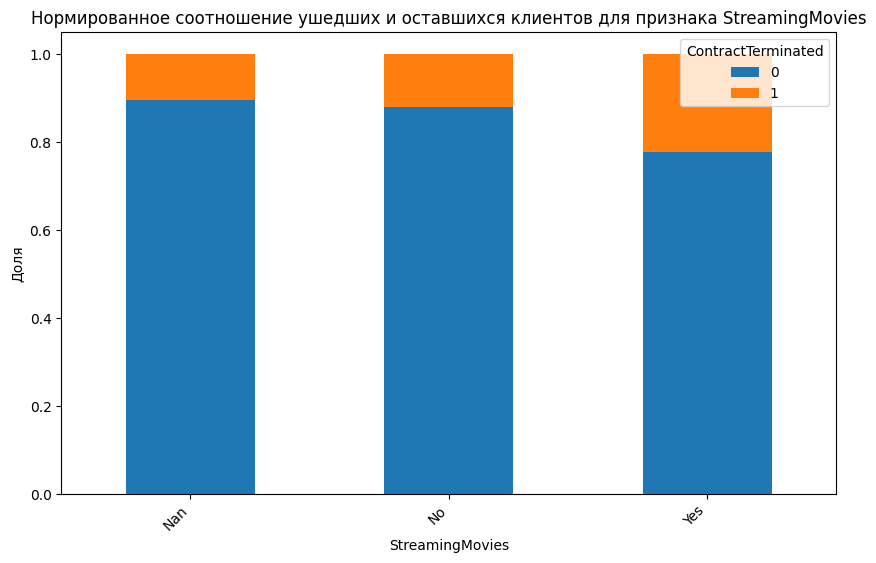

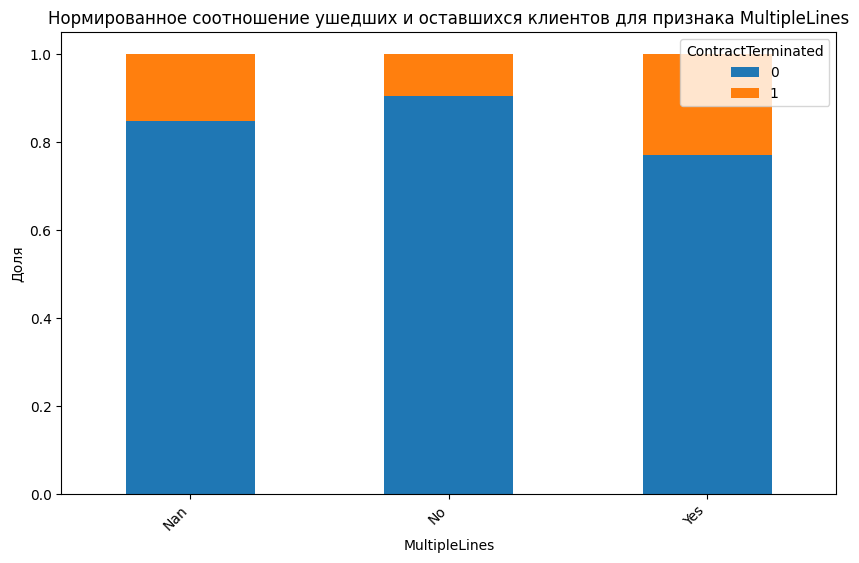

In [58]:
for column in categorical_columns:
    normalized_counts = data.groupby(column)['ContractTerminated'].value_counts(normalize=True).unstack()
    normalized_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
    
    plt.title(f'Нормированное соотношение ушедших и оставшихся клиентов для признака {column}')
    plt.xlabel(column)
    plt.ylabel('Доля')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='ContractTerminated', loc='upper right')
    plt.show()

1. Клиентов с помесячной оплатой больше, поэтому количество расторгаемых ими договоров, несмотря на то, что их больше, чем 1 и 2 года, нельзя назвать самым большим. 
2. Клиенты, которые выбрали опцию получения электронных счетов, также чаще расторгают договоры. 
3. Клиенты с электронными чеками чаще расторгают контракты. 
4. Пол не влияет на отток клиентов.
5. Пенсионеры реже расторгают контракты, однако их в 5 раз меньше, поэтому данное утверждение не может быть верным.
6. Клиенты, у которых нет партнера, чаще расторгают договоры.
7. Клиенты без детей чаще расторгают контракты.
8. Клиенты, использующие оптоволокно, чаще расторгают контракты. И в целом клиенты с интернетом чаще расторгают контракты.
9. Клиенты, у которых нет различных услуг, чаще расторгают контракты. Однако те, кому было предложены данные услуги, расторгают контракты в большем процентном соотношении. Особенно это касается тех, у кого есть услуги. Также отметим большое окличество клиентов, расторгших договор, у которых нет технической поддержки.


Бизнесу следует обратить на качество оказываемых услуг и улучшить техническую поддержку.

In [59]:
numerical_columns = ['MonthlyCharges', 'TotalCharges']

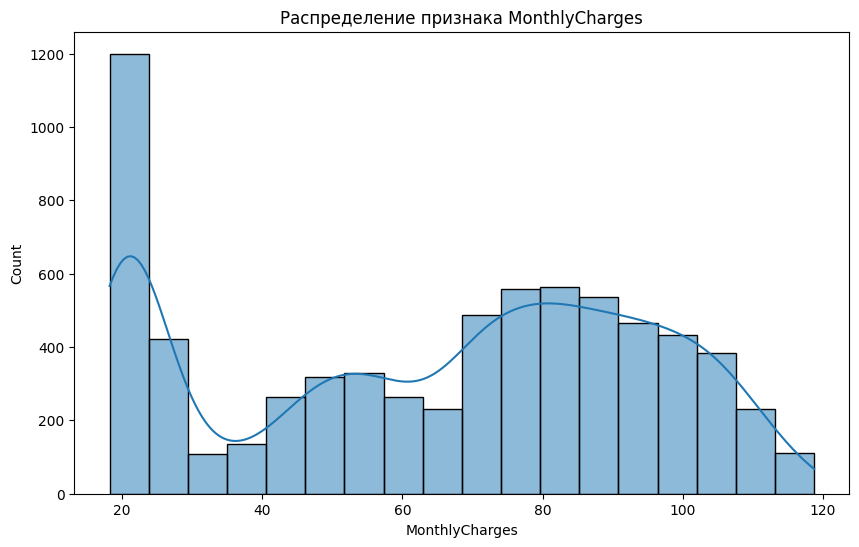

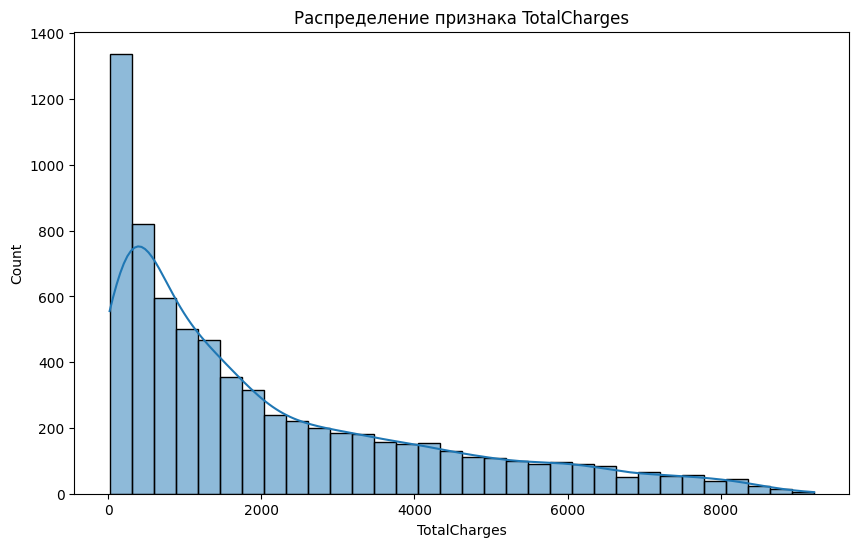

In [60]:
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], kde=True)
    plt.title(f'Распределение признака {column}')
    plt.show()

1. Большая часть клиентов платит менее 30 денежных единиц в месяц. Большинство клиентов используют самые дешевые тарифы. Однако имеется также значительная часть пользователей, которые платят более 70 ден.ед.
Распределение показывает две группы пользователей: с минимальными и максимальными тарифами.
2. Распределение признака TotalCharges показывает предыдущий вывод: большинство пользователей платят минимальную стоимость, однако есть люди, которые готовы платить большую цену. В этом распределении имеется правосторонний перекос.

## Промежуточный вывод

1. Клиентов с помесячной оплатой больше, поэтому количество расторгаемых ими договоров, несмотря на то, что их больше, чем 1 и 2 года, нельзя назвать самым большим. 
2. Клиенты, которые выбрали опцию получения электронных счетов, также чаще расторгают договоры. 
3. Клиенты с электронными чеками чаще расторгают контракты. 
4. Пол не влияет на отток клиентов.
5. Пенсионеры реже расторгают контракты, однако их в 5 раз меньше, поэтому данное утверждение не может быть верным.
6. Клиенты, у которых нет партнера, чаще расторгают договоры.
7. Клиенты без детей чаще расторгают контракты.
8. Клиенты, использующие оптоволокно, чаще расторгают контракты. И в целом клиенты с интернетом чаще расторгают контракты.
9. Клиенты, у которых нет различных услуг, чаще расторгают контракты. Однако те, кому было предложены данные услуги, расторгают контракты в большем процентном соотношении. Особенно это касается тех, у кого есть услуги. Также отметим большое окличество клиентов, расторгших договор, у которых нет технической поддержки.

Бизнесу следует обратить на качество оказываемых услуг и улучшить техническую поддержку.

1. Большая часть клиентов платит менее 30 денежных единиц в месяц. Большинство клиентов используют самые дешевые тарифы. Однако имеется также значительная часть пользователей, которые платят более 70 ден.ед.
Распределение показывает две группы пользователей: с минимальными и максимальными тарифами.
2. Распределение признака TotalCharges показывает предыдущий вывод: большинство пользователей платят минимальную стоимость, однако есть люди, которые готовы платить большую цену. В этом распределении имеется правосторонний перекос.

Я решила сгенерировать новый признак - длительность контракта абонента. По заданию мы не можем использовать его одновременно с переменными 'BeginDate' и 'EndDate'.

In [61]:
data['ContractDuration'] = (data['EndDate'] - data['BeginDate']).dt.days

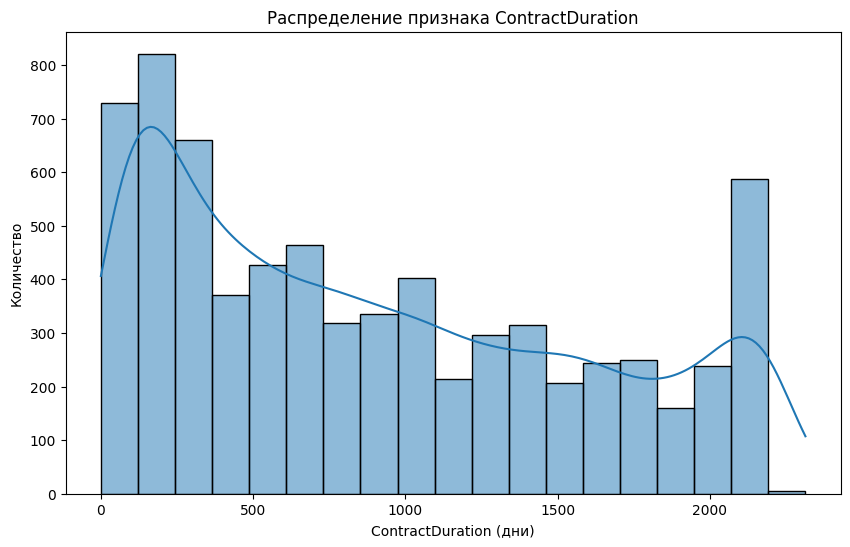

In [62]:
plt.figure(figsize=(10, 6))
sns.histplot(data['ContractDuration'], kde=True)
plt.title('Распределение признака ContractDuration')
plt.xlabel('ContractDuration (дни)')
plt.ylabel('Количество')
plt.show()

Большое количество клиентов имеет контракт с небольшой продолжительностью (до 500 дней). Есть клиенты, которые быстро уходят или пришли недавно, однако есть группа лояльных клиентов, которые долго с компанией и остаются с ней.

In [63]:
print(data.dtypes)

customerID                    object
BeginDate             datetime64[ns]
EndDate               datetime64[ns]
Type                          object
PaperlessBilling              object
PaymentMethod                 object
MonthlyCharges               float64
TotalCharges                 float64
gender                        object
SeniorCitizen                 object
Partner                       object
Dependents                    object
InternetService               object
OnlineSecurity                object
OnlineBackup                  object
DeviceProtection              object
TechSupport                   object
StreamingTV                   object
StreamingMovies               object
MultipleLines                 object
ContractTerminated             int32
ContractDuration               int64
dtype: object


In [64]:
data = data.drop(columns=['customerID', 'BeginDate', 'EndDate'])

Удалены ненужные столбцы customerID, BeginDate, EndDate.

Использую библиотеку phik

In [65]:
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

In [66]:
print(numerical_columns)

Index(['MonthlyCharges', 'TotalCharges', 'ContractDuration'], dtype='object')


In [67]:
print (categorical_columns)

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen',
       'Partner', 'Dependents', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines'],
      dtype='object')


С распределением все в порядке.

In [68]:
phik_matrix = data.phik_matrix(interval_cols=numerical_columns)

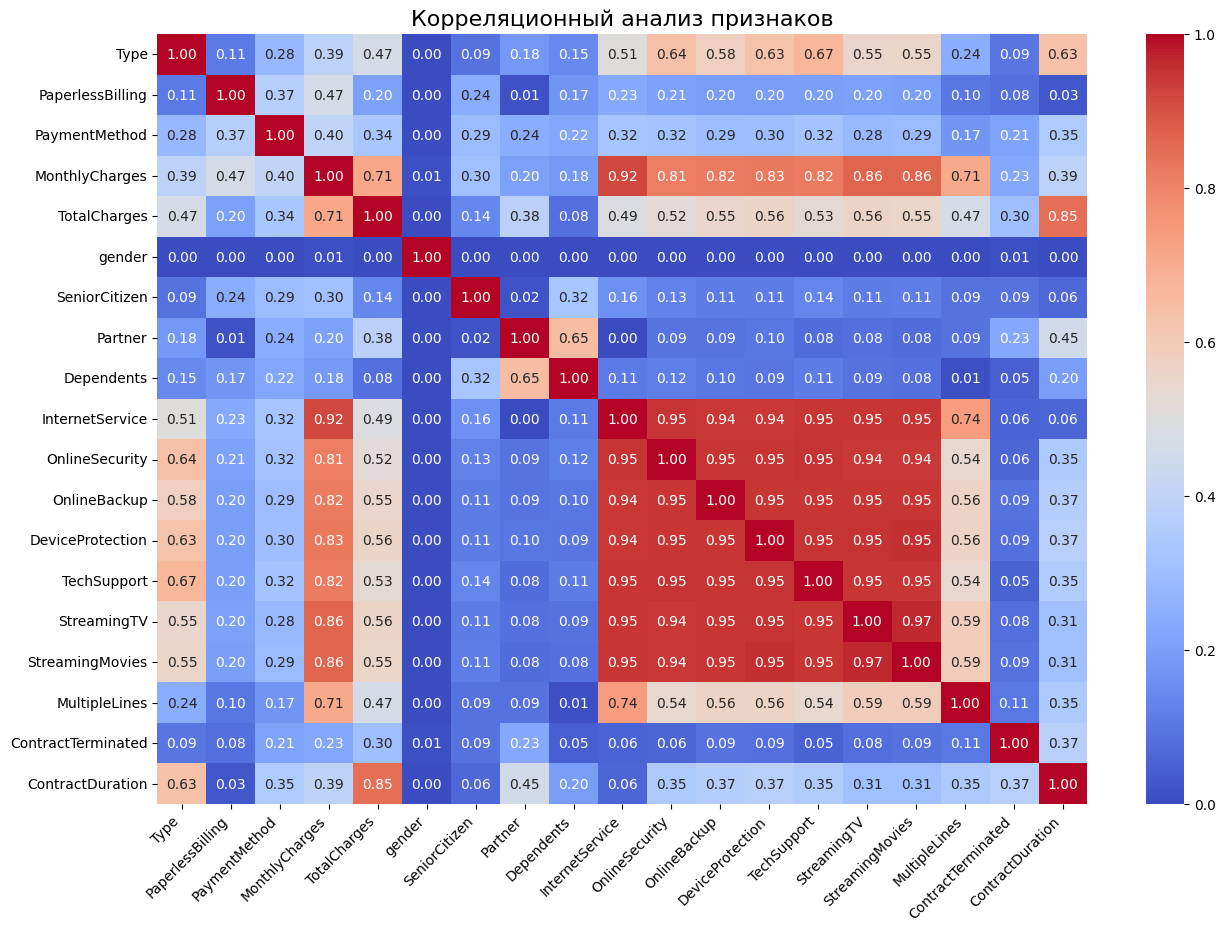

In [69]:
plt.figure(figsize=(15, 10))
sns.heatmap(phik_matrix.values, annot=True, fmt='.2f', cmap='coolwarm', vmin=0, vmax=1, 
            xticklabels=phik_matrix.columns, yticklabels=phik_matrix.index, 
            annot_kws={"fontsize": 10})
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('Корреляционный анализ признаков', fontsize=16)
plt.show()

1. Переменные OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV и StreamingMovies имеют высокую корреляцию. Клиенты, которые выбирают один из этих сервисов, часто выбирают и другие.

2. Удалены OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, TotalCharges, так как у них высокая корреляция с InternetService. В итоге оставлена только переменная InternetService.

3. Переменные MonthlyCharges и TotalCharges имеют умеренную положительную корреляцию. Общая сумма платежей растет с увеличением ежемесячных расходов.

4. Есть корреляция между типом контракта и различными сервисами.

5. Столбец ContractTerminated: чем меньше длительность контракта, тем выше вероятность его расторжения. Чм дольше клиент остается с компанией, тем больше сумма его общих платежей. Клиенты с более длительными контрактами имеют более высокие ежемесячные платежи. Клиенты с длительными контрактами также могут пользоваться большим количеством услуг.

6. Удален столбец gender, так как пол не влияет на отказ.

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                7043 non-null   object 
 1   PaperlessBilling    7043 non-null   object 
 2   PaymentMethod       7043 non-null   object 
 3   MonthlyCharges      7043 non-null   float64
 4   TotalCharges        7043 non-null   float64
 5   gender              7043 non-null   object 
 6   SeniorCitizen       7043 non-null   object 
 7   Partner             7043 non-null   object 
 8   Dependents          7043 non-null   object 
 9   InternetService     7043 non-null   object 
 10  OnlineSecurity      7043 non-null   object 
 11  OnlineBackup        7043 non-null   object 
 12  DeviceProtection    7043 non-null   object 
 13  TechSupport         7043 non-null   object 
 14  StreamingTV         7043 non-null   object 
 15  StreamingMovies     7043 non-null   object 
 16  Multip

In [71]:
data = data.drop(columns=['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                          'StreamingTV', 'StreamingMovies', 'TotalCharges', 'gender'])

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                7043 non-null   object 
 1   PaperlessBilling    7043 non-null   object 
 2   PaymentMethod       7043 non-null   object 
 3   MonthlyCharges      7043 non-null   float64
 4   SeniorCitizen       7043 non-null   object 
 5   Partner             7043 non-null   object 
 6   Dependents          7043 non-null   object 
 7   InternetService     7043 non-null   object 
 8   MultipleLines       7043 non-null   object 
 9   ContractTerminated  7043 non-null   int32  
 10  ContractDuration    7043 non-null   int64  
dtypes: float64(1), int32(1), int64(1), object(8)
memory usage: 577.9+ KB


# Подготовка и разделение данных

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                7043 non-null   object 
 1   PaperlessBilling    7043 non-null   object 
 2   PaymentMethod       7043 non-null   object 
 3   MonthlyCharges      7043 non-null   float64
 4   SeniorCitizen       7043 non-null   object 
 5   Partner             7043 non-null   object 
 6   Dependents          7043 non-null   object 
 7   InternetService     7043 non-null   object 
 8   MultipleLines       7043 non-null   object 
 9   ContractTerminated  7043 non-null   int32  
 10  ContractDuration    7043 non-null   int64  
dtypes: float64(1), int32(1), int64(1), object(8)
memory usage: 577.9+ KB


In [74]:
X = data.drop(columns=['ContractTerminated'])
y = data['ContractTerminated']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

In [76]:
print(f"Размерность тренировочных данных: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Размерность тестовых данных: X_test: {X_test.shape}, y_test: {y_test.shape}")

Размерность тренировочных данных: X_train: (5282, 10), y_train: (5282,)
Размерность тестовых данных: X_test: (1761, 10), y_test: (1761,)


In [77]:
categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns

In [78]:
print("Категориальные признаки:", categorical_features)
print("Числовые признаки:", numerical_features)

Категориальные признаки: Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'MultipleLines'],
      dtype='object')
Числовые признаки: Index(['MonthlyCharges', 'ContractDuration'], dtype='object')


In [79]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Обучение

RandomForest:

In [80]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

In [81]:
rf_params = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 10, 20],
}

In [82]:
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='roc_auc', n_jobs=-1)

GradientBoosting:

In [83]:
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

In [84]:
gb_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5, 7],
}

In [85]:
gb_grid = GridSearchCV(gb_pipeline, gb_params, cv=5, scoring='roc_auc', n_jobs=-1)

MLPClassifier:

In [86]:
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(random_state=RANDOM_STATE, max_iter=1000))
])

In [87]:
mlp_params = {
    'classifier__hidden_layer_sizes': [(100,), (100, 50), (100, 100, 50)],
    'classifier__alpha': [0.0001, 0.001],
}

In [88]:
mlp_grid = GridSearchCV(mlp_pipeline, mlp_params, cv=5, scoring='roc_auc', n_jobs=-1)

In [89]:
grids = {'RandomForest': rf_grid, 'GB': gb_grid, 'НС': mlp_grid}

In [90]:
for name, grid in grids.items():
    grid.fit(X_train, y_train)
    print(f"Лучшие гиперпараметры для {name}: {grid.best_params_}")
    print(f"Лучший результат ROC-AUC для {name}: {grid.best_score_}")
    print()

Лучшие гиперпараметры для RandomForest: {'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Лучший результат ROC-AUC для RandomForest: 0.8129350101379107

Лучшие гиперпараметры для GB: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Лучший результат ROC-AUC для GB: 0.9021561876560291

Лучшие гиперпараметры для НС: {'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (100,)}
Лучший результат ROC-AUC для НС: 0.7996879060299802



# Тестирование модели

Лучший ROC-AUC показал GradientBoostingClassifier с результатом 0.90. Худший результат показала нейросеть MLPClassifier - 0.79. Рандомный лес выдал 0,81.

In [91]:
best_model = max(grids.values(), key=lambda g: g.best_score_).best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC на тестовой выборке для лучшей модели: {roc_auc}')

ROC-AUC на тестовой выборке для лучшей модели: 0.9338333537256821


In [92]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy на тестовой выборке для лучшей модели: {accuracy}')

Accuracy на тестовой выборке для лучшей модели: 0.9091425326519024


Значение Значение ROC-AUC на тестовой выборке - 0,93.

Значение Accuracy на тестовой выборке: 0,90.

Это показывает на хорошее качество классификации и способность модели определять, ушел клиент или нет (0 или 1). Accuracy 0,90 означает, что модель классифицирует 90% примеров на тестовой выборке правильно.

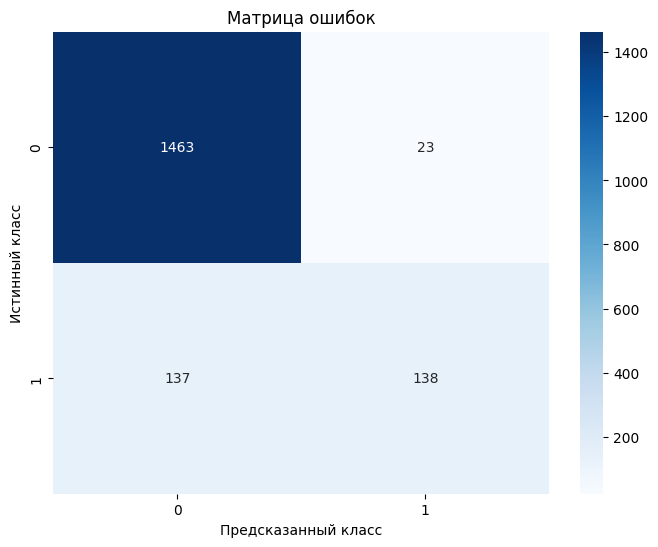

In [93]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

Модель правильно предсказала неуход клиентов в 1463 случае и предсказала уход в 137 случаях. Модель ошибклась в 161 случаях.

In [94]:
print("Информация о полноте и точности:")
print(classification_report(y_test, y_pred))

Информация о полноте и точности:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      1486
           1       0.86      0.50      0.63       275

    accuracy                           0.91      1761
   macro avg       0.89      0.74      0.79      1761
weighted avg       0.91      0.91      0.90      1761



Неуход клиентов:
Точность: 91%
Полнота: 98%
F1: 95%

Уход клиента:
Точность: 86%
Полнота: 50%
F1: 63%

Модель правильно классифицирует 91% уход или неуход клиентов.
Это означает, что полученная мождель справляется с предсказанием неухода клиента, однако испытывает сложности в ппредсказании точнсоти ухода клиентов.

In [95]:
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, scoring='roc_auc')

In [96]:
importances = result.importances_mean
feature_names = X_test.columns

In [97]:
sorted_indices = np.argsort(importances)[::-1]

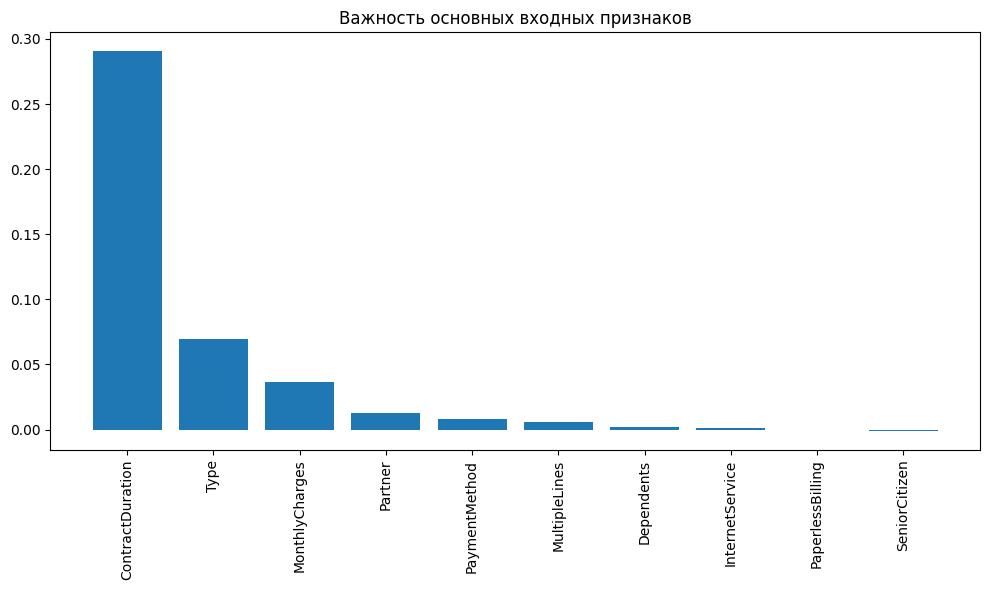

In [98]:
plt.figure(figsize=(10, 6))
plt.title('Важность основных входных признаков')
plt.bar(range(X_test.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_test.shape[1]), feature_names[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

Самыми важными признаками оказали:

- длительность контракта
- тип контракта
- размер ежемесячных платежей


Остальные признаки имеют низкую важность.

In [99]:
df_analys = X_test.copy()
df_analys['ContractTerminated'] = y_test

In [100]:
df_analys['ContractDuration_bins'] = pd.cut(df_analys['ContractDuration'], bins=10)

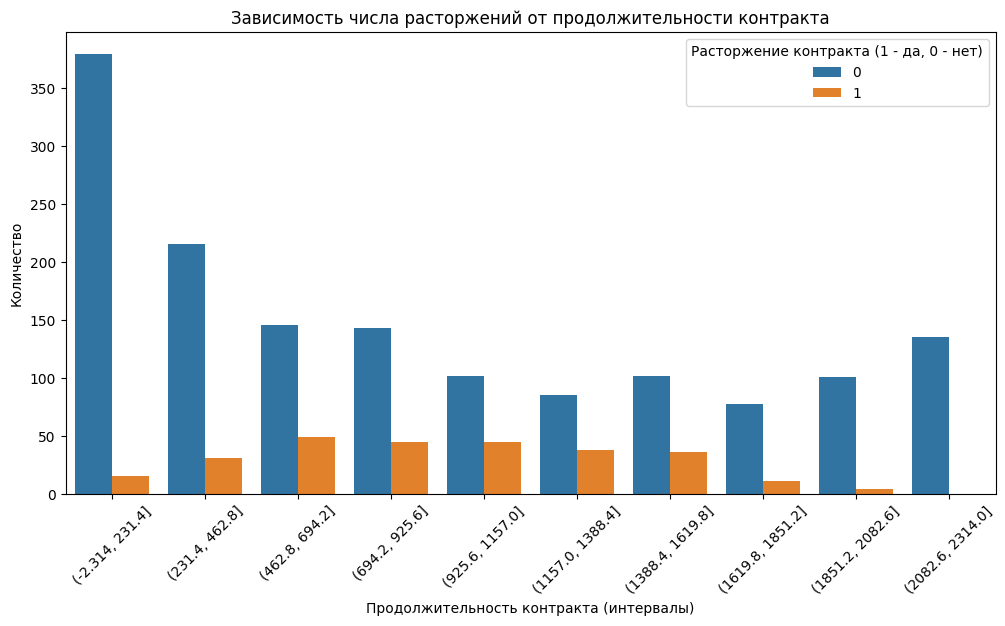

In [101]:
plt.figure(figsize=(12, 6))
sns.countplot(x='ContractDuration_bins', hue='ContractTerminated', data=df_analys)
plt.xlabel('Продолжительность контракта (интервалы)')
plt.ylabel('Количество')
plt.title('Зависимость числа расторжений от продолжительности контракта')
plt.legend(title='Расторжение контракта (1 - да, 0 - нет)')
plt.xticks(rotation=45)
plt.show()

1. Клиенты с самым коротким контрактом редко расторгают контракт. 
2. С увеличением длительности контракта уменьшается количество клиентов.
3. От 500 до 1500 дней наблюдается максимальное количество расторжение контрактами.

## Вывод

Получена модель, которая предсказывает, рассторгнет ли клиент контракт, с вероятностью 90%.

ROC-AUC на тестовой выборке для лучшей модели: 0.93

Accuracy на тестовой выборке для лучшей модели: 0.90

Рекомендации для бизнеса

Компании следует ввести большее разнообразие контрактов. Сейчас есть только контракты на месяц, год и два года.

Нужно попробовать ввести контракты на:
- 3 месяца
- 6 месяцев
- 9 месяцев

Также можно попробовать ввести тарифы с меньшими ценами, так как пользователей они больше привлекают.

Также компании нужно обратить внимание на качество своих сервисов и на техническую поддержку. Это поможет вдальнейшем удерживать пользователей.